In [12]:
!pip install pyqubo
!pip install docplex
!pip install cplex

In [14]:
from pyqubo import Array
import numpy as np
import math
import neal
import time
import docplex.mp.model as md
from itertools import permutations
from itertools import combinations
from itertools import combinations_with_replacement
import random
import matplotlib.pyplot as plt

Problem: Suppose you are filling rooms. People have floor preferences and preferences on who stays on the floor with them. Let there be $n$ people staying in the hotel.
Let the $m$-th floor have $k=n/m$ spots to fill. 

$$ H = \underbrace{ \sum_i \left(x_i -p_i \right)^2}_{\text{minimizes by floor preference}} + \underbrace{\sum_{ij, i \neq j} A_{ij} \left( x_{i,first} - x_{j,second} \right)^2}_{\text{minimizes by people preference}}$$ for infinite possible occupancy by floor.

LIMIT OCCUPANCY PER FLOOR

$$ H = \underbrace{ \sum_i \left(x_i -p_i \right)^2}_{\text{minimizes by floor preference}} + \underbrace{\sum_{ij, i \neq j} A_{ij} \left( x_{i,first} - x_{j,second} \right)^2}_{\text{minimizes by people preference}} + \underbrace{\left( \left( \sum_{i=1}^m i  \right) \times (k-0.25) - \sum_{i} x_i\right)^2}_{\text{ ensures k people on each floor, prefers less}} + \underbrace{\left( m!^{(k-0.25)} - \prod_{i} x_i \right)^2}_{\text{ further ensures k people on each floor, prefers less}}$$

$$ H = \underbrace{ \sum_i \left(x_i -p_i \right)^2}_{\text{minimizes by floor preference}} + \underbrace{\sum_{ij, i \neq j} A_{ij} \left( x_{i,first} - x_{j,second} \right)^2}_{\text{minimizes by people preference}} + \underbrace{\left( \frac{m(m+1)}{2} \times (k-0.25) - \sum_{i} x_i\right)^2}_{\text{ ensures k people on each floor, prefers less}} + \underbrace{\left( m!^{(k-0.25)} - \prod_{i} x_i \right)^2}_{\text{ further ensures k people on each floor, prefers less}}$$ where $m$ is the number of floors and $k$ is the number of occupants per floor.

In [50]:
# Set random seed
np.random.seed(3)
# Define Number of Pairs to be Matched
# n is the number of people
# m is the number of floors
# Require that m*k > n
n,m =8,2
k = n/m
floor_choice = np.random.randint(1,m+1,n)
#floor_choice = [2,2,2,2,2,1,1,1]
# number each person
y=np.linspace(1,n,n,dtype=int)
# Create random array of random combinations of the 10 indices ordered
# for the first group's preferences:
first = np.array([random.sample(list(permutations(y,n)),n)]).reshape(n,n)
# second group's preferences:
# Transpose ensures that they order down rather than across (no repeats in columns of matrix)
second = np.array([random.sample(list(permutations(np.linspace(1,n,n,dtype=int),n)),n)]).reshape(n,n).transpose()
A=first*second # Lower value = more affinity for each other
A=1/A  # Higher value = more affinity for each other


### QUBO

No limit on floor occupancy

In [42]:
fill=md.Model(name='Filling Rooms')
x=np.array(fill.integer_var_list(n,lb=1,ub=m,name='order'))
if k==0.75:
  fill.add_constraints_(x[i]!=x[j] for i in range(len(x)) for j in range(len(x)) if i!=j )
H1 = 99*np.sum( [ [ ( floor_choice[i]-x[i] )**2 ] for i in range(n)] )
H2 = 50*np.sum( [ [ A[i,j]*(x[i]-x[j])**2 ] for i in range(n) for j in range(n) if i!=j ] )
fill.minimize(H1+H2)
solution = np.array(fill.solve().get_value_list(x.flatten()))
print('Floor Choice :', floor_choice)
print('Solution :', solution)

Floor Choice : [3 1 2 4 1 1 1 2]
Solution : [3. 1. 2. 3. 1. 2. 1. 2.]


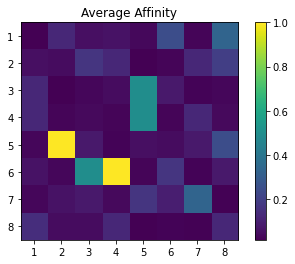

Person 1 wanted floor  3  and was placed on floor  3
Person 2 wanted floor  1  and was placed on floor  1
Person 3 wanted floor  2  and was placed on floor  2
Person 4 wanted floor  4  and was placed on floor  3
Person 5 wanted floor  1  and was placed on floor  1
Person 6 wanted floor  1  and was placed on floor  2
Person 7 wanted floor  1  and was placed on floor  1
Person 8 wanted floor  2  and was placed on floor  2


In [43]:
plt.imshow(A, interpolation='nearest',cmap='viridis')
plt.yticks([i for i in range(n)],y)
plt.xticks([i for i in range(n)],y)
plt.title('Average Affinity')
plt.colorbar()
plt.show()
for i in range(n):
  print('Person '+str(i+1)+' wanted floor ',floor_choice[i],' and was placed on floor ', int(solution[i]))

Limit on floor occupancy

In [44]:
fill=md.Model(name='Filling Rooms')
x=np.array(fill.integer_var_list(n,lb=1,ub=m,name='order'))
if k==0.75:
  fill.add_constraints_(x[i]!=x[j] for i in range(len(x)) for j in range(len(x)) if i!=j )
H1 = 50*np.sum( [ [ ( floor_choice[i]-x[i] )**2 ] for i in range(n)] )
H2 = 99*np.sum( [ [ A[i,j]*(x[i]-x[j])**2 ] for i in range(n) for j in range(n) if i!=j ] )
H3 = 999*((k-0.25)*m*(m+1)/2 - np.sum(x))**2
#H4 = 999*(np.prod(x)-np.math.factoprial(m)^k)**2
fill.minimize(H1+H2+H3)
solution = np.array(fill.solve().get_value_list(x.flatten()))
print('Floor Choice :', floor_choice)
print('Solution :', solution)

Floor Choice : [3 1 2 4 1 1 1 2]
Solution : [2. 2. 2. 3. 2. 2. 2. 2.]


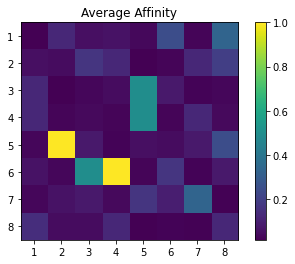

Person 1 wanted floor  3  and was placed on floor  2
Person 2 wanted floor  1  and was placed on floor  2
Person 3 wanted floor  2  and was placed on floor  2
Person 4 wanted floor  4  and was placed on floor  2
Person 5 wanted floor  1  and was placed on floor  2
Person 6 wanted floor  1  and was placed on floor  2
Person 7 wanted floor  1  and was placed on floor  2
Person 8 wanted floor  2  and was placed on floor  2


In [45]:
plt.imshow(A, interpolation='nearest',cmap='viridis')
plt.yticks([i for i in range(n)],y)
plt.xticks([i for i in range(n)],y)
plt.title('Average Affinity')
plt.colorbar()
plt.show()
for i in range(n):
  print('Person '+str(i+1)+' wanted floor ',floor_choice[i],' and was placed on floor ', int(solution[i]))

MANUAL SOLUTION

In [46]:
combinations_with_replacement,
floors=np.linspace(1,m,m,dtype=int)
C = np.array(list(combinations_with_replacement(floors, n)))
H1 = [ 99*np.sum( [ [ ( floor_choice[j]-C[i][j] )**2 ] for j in range(n)] ) for i in range(len(C))  ]
#H2 = [ np.sum([ [A[i,j]*(C[p,i]-C[p,j])**2 ]  for i in range(n) for j in range(n) if i!=j] ) for p in range(len(C)) ] 
H2=[0]*len(C)
H3 = [ [  999*((k-0.25)*m*(m+1)/2 - np.sum(C[i]))**2 ] for i in range(len(C)) ]
H4 = [ [ 999*(np.math.factorial(m)**(k-0.25) - np.prod(C[i]))**2] for i in range(len(C)) ]
H=[0]*len(C)
for i in range(len(C)):
  H[i]=H1[i]+H2[i]+H3[i]+H4[i]
solution = np.min(H)
for i in range(len(C)):
  if H[i]==solution:
    l=i

# C[l] is the solution

print('Solution :', C[l])

Solution : [1 2 2 2 2 2 2 4]


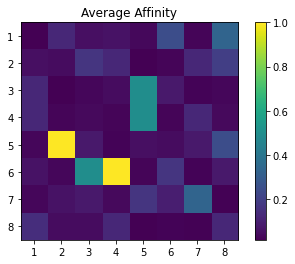

Person 1 wanted floor  3  and was placed on floor  1
Person 2 wanted floor  1  and was placed on floor  2
Person 3 wanted floor  2  and was placed on floor  2
Person 4 wanted floor  4  and was placed on floor  2
Person 5 wanted floor  1  and was placed on floor  2
Person 6 wanted floor  1  and was placed on floor  2
Person 7 wanted floor  1  and was placed on floor  2
Person 8 wanted floor  2  and was placed on floor  4


In [47]:
plt.imshow(A, interpolation='nearest',cmap='viridis')
plt.yticks([i for i in range(n)],y)
plt.xticks([i for i in range(n)],y)
plt.title('Average Affinity')
plt.colorbar()
plt.show()
for i in range(n):
  print('Person '+str(i+1)+' wanted floor ',floor_choice[i],' and was placed on floor ', int(C[l][i]))